## 🔧 Install CLIP


In [25]:
pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to c:\users\user\appdata\local\temp\pip-req-build-iivram2q
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\User\AppData\Local\Temp\pip-req-build-iivram2q'


## 🖼️ Zero-Shot Classification with CLIP

In this section, we:
1. Load the CLIP model (`ViT-B/32`) and preprocessing function.  
2. Download an example image from the web.  
3. Define candidate text labels (diagram, dog, cat).  
4. Encode both the image and text using CLIP.  
5. Compare their similarity and output probabilities for each label.

In [26]:
import torch
import clip
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt



# ------------------------------
# 1. Load CLIP model + preprocessing
# ------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"   # use GPU if available
model, preprocess = clip.load("ViT-B/32", device=device) # load CLIP with ViT-B/32 backbone

# ------------------------------
# 2. Load an example image
# ------------------------------
url = "https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png"
image = Image.open(BytesIO(requests.get(url).content))    # download image from URL
image_input = preprocess(image).unsqueeze(0).to(device)  # preprocess + add batch dimension

# ------------------------------
# 3. Define candidate text labels
# ------------------------------
# These are the categories we want CLIP to choose from
text_labels = ["a diagram", "a dog", "a cat"]

# Convert text to tokens (numerical IDs for CLIP)
text = clip.tokenize(text_labels).to(device)

# ------------------------------
# 4. Encode image and text with CLIP
# ------------------------------
with torch.no_grad():  # no gradient calc needed for inference
    image_features = model.encode_image(image_input)  # embed image into CLIP space
    text_features = model.encode_text(text)           # embed each label into CLIP space

    # CLIP compares similarities between image and text embeddings
    logits_per_image, logits_per_text = model(image_input, text)

    # Convert raw similarity scores into probabilities
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probabilities:", probs)
# Example output: [[0.99, 0.004, 0.002]] → 99% "diagram", very low for dog/cat


Label probabilities: [[0.9927   0.004253 0.003016]]


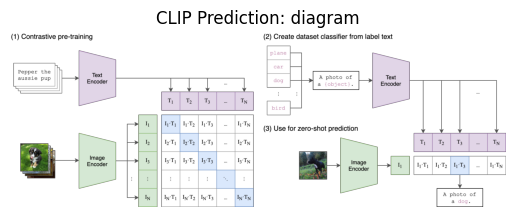

In [27]:
plt.imshow(image)
plt.title("CLIP Prediction: " + ["diagram", "dog", "cat"][probs.argmax()])
plt.axis("off")
plt.show()

## 🐶 Zero-Shot Classification on a Local Image

In this step, we:
1. Load the CLIP model and preprocessing pipeline.  
2. Load a local image (`images.jpeg`) from the working directory.  
3. Define a set of candidate labels (dog, cat, car, tree, traffic light).  
4. Encode both the image and the text labels into CLIP’s joint embedding space.  
5. Compute similarity scores and turn them into probabilities.  
6. Print the results and visualize the image with the **top predicted label** as the title.


Zero-Shot Classification Results:
a traffic light : 1.000
a car      : 0.000
a tree     : 0.000
a dog      : 0.000
a cat      : 0.000


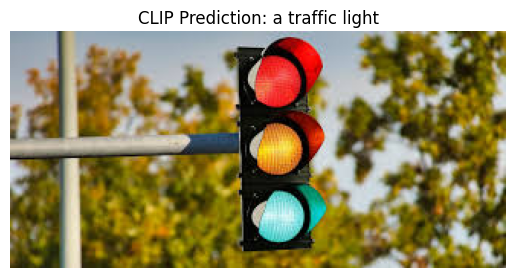

In [ ]:
# ------------------------------
# 2. Load your local image
# ------------------------------
# Path to the image file in the current directory
image_path = "traffic_light.jpeg"  

# Open the image and ensure it's in RGB format (CLIP expects RGB input)
image = Image.open(image_path).convert("RGB")

# Preprocess the image: resize, crop, normalize, etc.
# unsqueeze(0) adds a batch dimension → shape becomes (1, C, H, W)
image_input = preprocess(image).unsqueeze(0).to(device)

# ------------------------------
# 3. Define candidate labels (class names)
# ------------------------------
# CLIP will compare the image to these text prompts
class_names = ["a dog", "a cat", "a car", "a tree", "a traffic light"]

# Convert text labels into token IDs that CLIP can understand
text = clip.tokenize(class_names).to(device)

# ------------------------------
# 4. Run CLIP (inference)
# ------------------------------
with torch.no_grad():  # inference mode: faster, uses less memory
    # Encode the image into CLIP’s embedding space
    image_features = model.encode_image(image_input)

    # Encode all candidate text labels into the same space
    text_features = model.encode_text(text)

    # Compute similarity scores between image and each text label
    logits_per_image, _ = model(image_input, text)

    # Convert raw similarity scores into probabilities
    probs = logits_per_image.softmax(dim=-1).cpu().numpy().squeeze()

# ------------------------------
# 5. Print results
# ------------------------------
print("\nZero-Shot Classification Results:")
# Sort labels by probability (highest first) and print them
for label, p in sorted(zip(class_names, probs), key=lambda x: -x[1]):
    print(f"{label:10s} : {p:.3f}")

# ------------------------------
# 6. Show image with top prediction
# ------------------------------
plt.imshow(image)
# Display the label with the highest probability as the title
plt.title("CLIP Prediction: " + class_names[probs.argmax()])
plt.axis("off")  # hide axes for cleaner visualization
plt.show()


## 🔎 Text → Image Retrieval with CLIP

In this section, we turn CLIP into a **mini search engine**:  
- First, we load all images from a folder (`images/`) and encode them once into CLIP’s embedding space.  
- Then, we define a `search()` function that:  
  1. Takes a natural language query (e.g., *"a red car on the road"*).  
  2. Encodes the query into the same space as the images.  
  3. Computes cosine similarity between the query and every image.  
  4. Returns the **Top-K most relevant images**, along with similarity scores.  
- This shows how CLIP can link **free text** to **visual content** without any additional training.  

In [29]:
import os, glob
import numpy as np


# ------------------------------
# 1. Point to your image folder
# ------------------------------
# Put ~10–50 images here (jpg/png). Example:
# demo_images/
#   ├─ dog.jpg
#   ├─ cat.png
#   ├─ car_1.jpg
#   └─ ship.jpeg
img_dir = "images"  # change to your folder name
paths = sorted(glob.glob(os.path.join(img_dir, "*.*")))
assert len(paths) > 0, f"No images found in '{img_dir}'. Add a few JPG/PNG files."

# ------------------------------
# 2. Load + preprocess all images
# ------------------------------
def load_rgb(path):
    # CLIP expects 3-channel RGB images
    return Image.open(path).convert("RGB")

pil_images = [load_rgb(p) for p in paths]

# Stack preprocessed tensors into a batch: (N, C, H, W)
images_tensor = torch.stack([preprocess(img) for img in pil_images]).to(device)

# ------------------------------
# 3. Encode the images once (cacheable)
# ------------------------------
with torch.no_grad():
    img_feats = model.encode_image(images_tensor)  # (N, D)
    # Normalize features → cosine similarity works via dot product
    img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

# ------------------------------
# 4. A search() function: text → top-K similar images
# ------------------------------
import clip

def search(query, topk=5, show_plot=True):
    """
    Given a natural language query, return the top-K matching images.
    """
    # Tokenize and encode the text prompt
    text_tok = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_feat = model.encode_text(text_tok)        # (1, D)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)

        # Similarity for each image: (N, D) @ (D, 1) → (N, 1)
        sims = (img_feats @ text_feat.T).squeeze(1)    # (N,)

        # Indices of top-K highest scores
        topk = min(topk, len(paths))
        values, idx = sims.topk(topk)

    # Print ranked results
    print(f"\nQuery: {query}")
    for r, (i, s) in enumerate(zip(idx.tolist(), values.tolist()), 1):
        print(f"{r:>2}. {paths[i]}   (score={s:.3f})")

    # Optional: show thumbnails of top-K
    if show_plot:
        cols = min(topk, 5)
        rows = int(np.ceil(topk / cols))
        plt.figure(figsize=(3.2*cols, 3.2*rows))
        for j, i in enumerate(idx.tolist(), 1):
            plt.subplot(rows, cols, j)
            plt.imshow(pil_images[i])
            plt.title(os.path.basename(paths[i]), fontsize=9)
            plt.axis("off")
        plt.suptitle(f"Top-{topk} for: {query}", y=0.98)
        plt.tight_layout()
        plt.show()

    # Return the file paths of matches
    return [paths[i] for i in idx.tolist()]

💡 Try it out:  
```python
search("a dog")
search("a man with a suit")
```


Query: a man with a suit
 1. images\person.jpg   (score=0.256)
 2. images\person_2.png   (score=0.203)
 3. images\person_pc.jpg   (score=0.193)
 4. images\cat.jpg   (score=0.192)
 5. images\dog.jpg   (score=0.189)


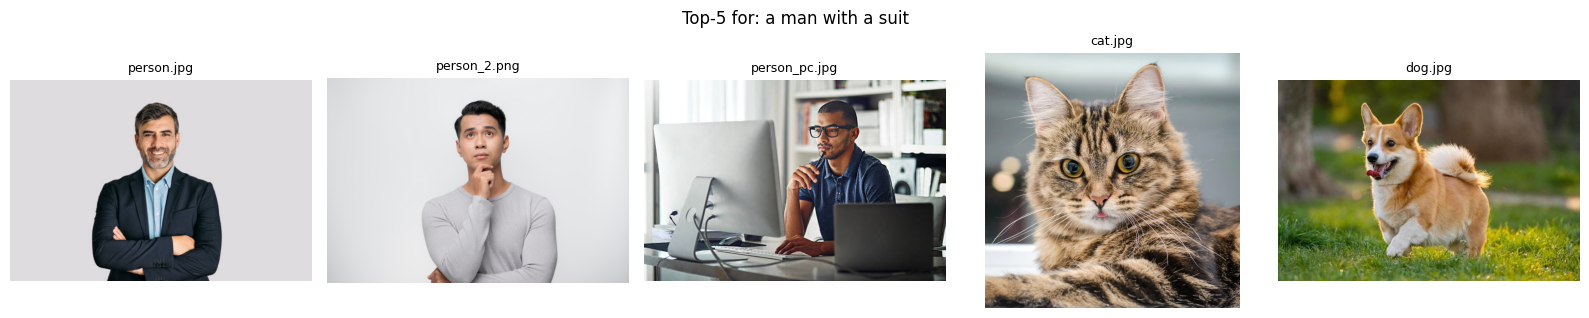

['images\\person.jpg',
 'images\\person_2.png',
 'images\\person_pc.jpg',
 'images\\cat.jpg',
 'images\\dog.jpg']

In [30]:
search("a man with a suit")

## 🖼️ Image → Text Retrieval with CLIP

In this step, we let CLIP decide **which caption best matches an image**:

1. Load a local image (`pc.jpg` in this example).  
2. Provide a list of **candidate captions** (e.g., *“a dog running on grass”*, *“a computer with RGB lights”*).  
3. Encode the image and all captions into CLIP’s shared embedding space.  
4. Compute similarities between the image and each caption.  
5. Rank captions by probability and show the **Top-K results**.  
6. Display the image with the **best caption prediction** as its title.


Image: images/pc.jpg
Top captions:
 1. a computer with RGB lights   (p=0.187)
 2. a man in a suit   (p=0.169)
 3. a big green tree   (p=0.166)
 4. a car on the road   (p=0.165)
 5. a dog running on grass   (p=0.159)


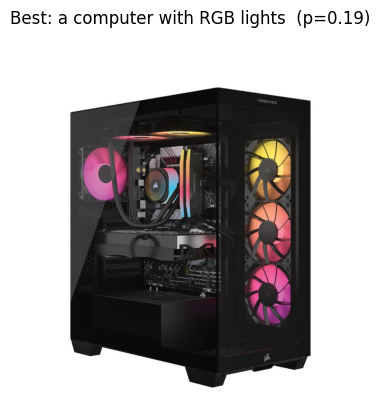


Best caption: a computer with RGB lights


In [32]:
def best_caption_for_image(image_path, candidate_captions, topk=5, show_plot=True):
    """
    Given an image and a list of candidate captions, return the most likely caption
    according to CLIP and print Top-K results with probabilities.
    """
    # 1) Load & preprocess the image
    pil_img = Image.open(image_path).convert("RGB")
    image = preprocess(pil_img).unsqueeze(0).to(device)  # (1, C, H, W)

    # 2) Tokenize all candidate captions
    text_tokens = clip.tokenize(candidate_captions).to(device)

    # 3) Encode image & text and compare
    with torch.no_grad():  # inference mode (faster, less memory)
        # Encoders map both modalities into the same embedding space
        image_feats = model.encode_image(image)              # (1, D)
        text_feats  = model.encode_text(text_tokens)         # (N, D)

        # Normalize so dot product ≈ cosine similarity
        image_feats = image_feats / image_feats.norm(dim=-1, keepdim=True)
        text_feats  = text_feats  / text_feats.norm(dim=-1, keepdim=True)

        # Similarity scores: (1, D) @ (D, N) → (1, N)
        sims = image_feats @ text_feats.T                    # (1, N)

        # Turn similarities into probabilities over the N captions
        probs = sims.softmax(dim=-1).squeeze(0)              # (N,)

    # 4) Rank captions
    topk = min(topk, len(candidate_captions))
    values, indices = probs.topk(topk)

    print(f"\nImage: {image_path}")
    print("Top captions:")
    for r, (idx, val) in enumerate(zip(indices.tolist(), values.tolist()), 1):
        print(f"{r:>2}. {candidate_captions[idx]}   (p={val:.3f})")

    # 5) show image with the best caption as title
    if show_plot:
        plt.imshow(pil_img)
        best_idx = indices[0].item()
        plt.title(f"Best: {candidate_captions[best_idx]}  (p={values[0].item():.2f})")
        plt.axis("off")
        plt.show()

    # Return best caption + full prob dict
    best = candidate_captions[indices[0].item()]
    prob_dict = {cap: probs[i].item() for i, cap in enumerate(candidate_captions)}
    return best, prob_dict

# ------------ Demo ------------
image_path = "images/pc.jpg"  # put your image in the same folder

candidate_captions = [
    "a dog running on grass",
    "a cat sitting on a sofa",
    "a computer with RGB lights",
    "a man in a suit",
    "a big green tree",
    "a car on the road"
]

best, probs = best_caption_for_image(image_path, candidate_captions, topk=5, show_plot=True)
print("\nBest caption:", best)